In [12]:
import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from tester import Tester

In [13]:
OLLAMA_API = "http://localhost:11434/v1"
HEADERS = {"Content-Type": "application/json"}
MODEL = "llama3.2"
API_KEY = 'ollama'

In [14]:
load_dotenv(override=True)
# os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
hf_token = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [15]:
openai = OpenAI(base_url=OLLAMA_API, api_key=API_KEY)

In [16]:
%matplotlib inline

In [17]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [18]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [19]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [20]:
def ollama(item):
    response = openai.chat.completions.create(
        model=MODEL, 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $119.95 Truth: $374.41 Error: $254.46 SLE: 1.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $27.92 Truth: $225.11 Error: $197.19 SLE: 4.23 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $28.50 Truth: $61.68 Error: $33.18 SLE: 0.57 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $249.00 Truth: $599.99 Error: $350.99 SLE: 0.77 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $12.00 Truth: $16.99 Error: $4.99 SLE: 0.11 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $17.95 Truth: $31.99 Error: $14.04 SLE: 0.31 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $125.00 Truth: $101.79 Error: $23.21 SLE: 0.04 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $439.00 Truth: $289.00 Error: $150.00 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $3,699.00 Truth: $635.86 Error: $3,063.14 SLE: 3.10 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $22.99 Truth: $65.99 Error: $43.00 SLE: 

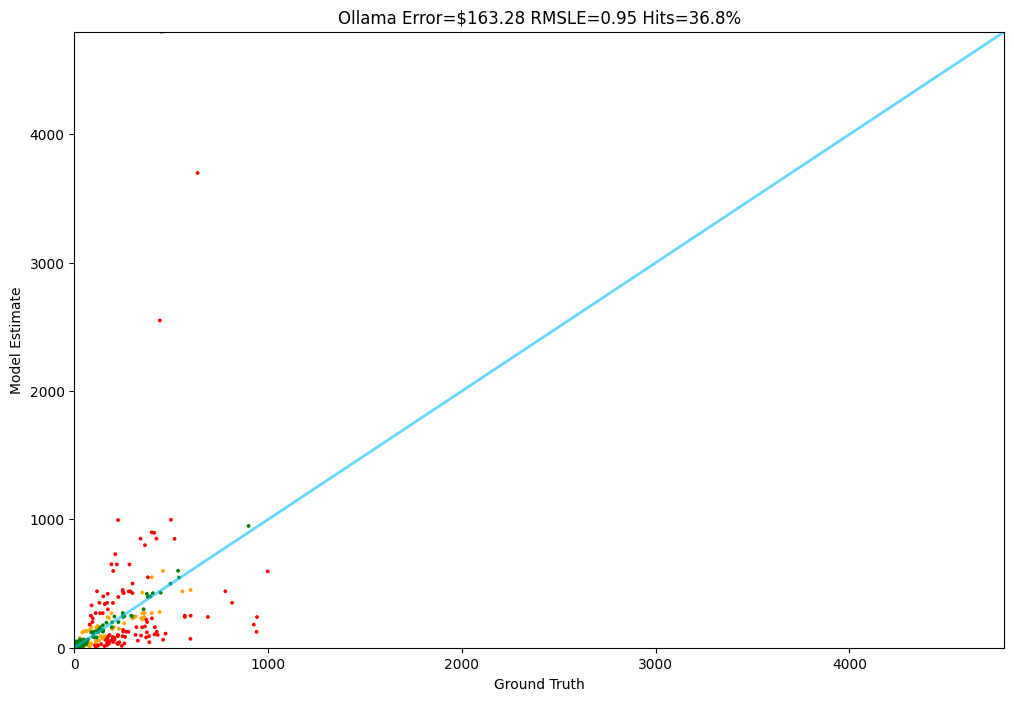

In [21]:
tester = Tester(predictor=ollama, data=test)
tester.run()